In [2]:
import numpy as np 
import sys 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import random
import os 
from matplotlib import colors as mcolors


## Loading the data

In [3]:
filename = "../data/rawdata_phasediag_tpri080.txt"
unsortdata =  np.loadtxt(filename,comments="#")  
data = np.array( [ unsortdata[i] for i in np.lexsort((-unsortdata[:,0], unsortdata[:,4], unsortdata [:,3], unsortdata[:,-1]) ) ] ) 
st = 50. # defines the stopping scale
loc = np.where( (data[:,8] > st) | (data[:,9] > st) | (data[:,10] > st) |(data[:,11] > st)  ) 
data = data[loc]
tpri   = sorted(set(data[:,3]))
occs   = sorted(set(data[:,4]))
top    = np.array([data[(data[:,4]== n) & (data[:,-1]==0.)][0] for n in occs])
bottom = np.array([data[(data[:,4]== n) & (data[:,-1]==1.)][0] for n in occs])
top    = top[np.argsort(top[:,4])] 
bottom = bottom[np.argsort(bottom[:,4])]

## Initialize figure and instability vectors

In [4]:
#fig = plt.figure(facecolor ='w') 
#possible instability vectors 
def getvec(arr): 
    vectors    = np.vstack({tuple(row) for row in np.array([[a[6],a[7],a[5]] for a in arr])})
    wh = [np.where((arr[:,6]==v[0]) & (arr[:,7]==v[1])) for v in vectors]
    span = np.array([[np.min(arr[w,4]),np.max(arr[w,4])] for w in wh])
    vectors = vectors[np.argsort(span[:,0])]
    span = span[np.argsort(span[:,0])]
    rec = [1.-span[0][0]]
    for i in range(span.shape[0]-1): rec.append(1.-(span[i][1]+span[i+1][0])/2.)
    rec.append(1.-span[-1][1])
    return vectors, span , rec
vectorsb,spanb, recb = getvec(bottom)
vectorst,spant, rect = getvec(top)

In [5]:
Blues = plt.get_cmap('Blues')
Greens= plt.get_cmap('Greens')
def asscol(arr,vectors,cmap): 
    colmap  = plt.get_cmap(cmap)
    offs    = 0.1 
    def dpp(a,b): 
        return np.sqrt((a-np.pi)**2.+(b-np.pi)**2)
    M=np.max([dpp(v[0],v[1]) for v in vectors[vectors[:,-1]==0.]])
    m=np.min([dpp(v[0],v[1]) for v in vectors[vectors[:,-1]==0.]])
    d = [ dpp(v[0],v[1])*(1.-offs)/(M-m)for v in vectors] # how much each vector is close to pi,pi
    colspan = [colmap(d[i]) if vectors[i,-1]==0. else matplotlib.colors.to_rgb("black")  for i in range(vectors.shape[0])] 
    def cond(i,j): 
        return (arr[i][6]==vectors[j][0]) & (arr[i][7]==vectors[j][1]) & (arr[i,5] == vectors[j][2])
    return [ [colspan[j] for j in range(vectors.shape[0]) if cond(i,j)][0]   for i in range(arr.shape[0])]    
def marks(arr): 
    return  ['o' if a[5]==0 else '*' for a in arr ]
#asscol(top,vectorst,'Blues')

In [6]:
inco  =  np.where ( (top[:,5] ==0. ) & ( (np.abs(top[:,6]-np.pi)>1.e-1)  | (np.abs(top[:,7] -np.pi) > 1.e-1)) )
comme =  np.where (top[:,5] ==0. ) and np.where (  (np.abs(top[:,6]-np.pi)<1.e-1)  & (np.abs(top[:,7] -np.pi) < 1.e-1) )
char  =  np.where (top[:,5] ==1.)

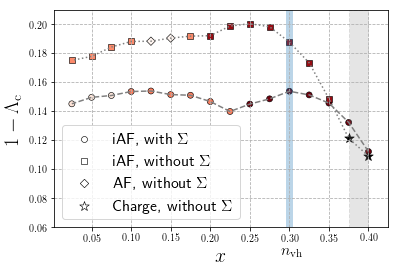

In [12]:
fig=plt.figure()
def form(a): 
    return "{:3.2f}".format(a)

ax = fig.add_subplot(111)

lcol=np.array(asscol(top,vectorst,'Reds'))[inco]
commcol = np.array(asscol(top,vectorst,'Reds'))[comme]
 
def util(a):
    #return (1.-a)**2 
    return a
plt.clf()
plt.plot(1.-top[:,4],util(top[:,0]),color='grey',linestyle='dotted')
plt.plot(1.-bottom[:,4],util(bottom[:,0]),color='grey',linestyle ='dashed')
plt.scatter(1.-bottom[:,4],util(bottom[:,0]),c=asscol(bottom,vectorsb,'Reds'),marker='o',edgecolor='black', linewidth='0.6',label =r'iAF, with $\Sigma$')# label = r'with $\Sigma$')
plt.scatter(1.-top[inco,4],util(top[inco,0]),c=lcol, marker='s',edgecolor='black', linewidth='0.6', label = r'iAF, without $\Sigma$')#,label =r'without $\Sigma$')
plt.scatter(1.-top[comme,4],util(top[comme,0]),c=commcol, marker='D',edgecolor='black', linewidth='0.6', label = r'AF, without $\Sigma$')


if np.sum([1. for v in top[top[:,5]==1.]])>0.5 :     
    plt.axvspan(1.-np.min(top[top[:,5]==1,4]),1.-np.max(top[top[:,5]==1,4]),linestyle ='dashed',color = 'grey',alpha=0.2)
    plt.scatter(1.-top[top[:,5]==1.,4],util(top[top[:,5]==1.,0]),c='black', s = 100.0, marker='*', edgecolor='black', linewidth='0.6',label =r'Charge, without $\Sigma$')#,label =r'without $\Sigma$')


rectangles = False
if rectangles : 
    for i in range(1,vectorsb.shape[0]-1): 
        #lab = r'('+form(vectorsb[i][0])+r','+form(vectorsb[i][1])+r')'
        ax.axvspan(recb[i],recb[i+1],alpha=0.5,fill=False, linestyle = 'dashed')# color = colorsb[i],label=lab) 
    for i in range(1,vectorst.shape[0]-1):
        ax.axvspan(rect[i],rect[i+1],alpha=0.5,fill=False, linestyle = 'dotted')
plt.axvspan(0.296,0.304,alpha=0.3,fill='indigo')
plt.ylim([0.06, 0.21])
plt.grid(linestyle='dashed')
plt.legend(fontsize = 16)
plt.xlabel(r"$x$",fontsize=20)
plt.ylabel(r"$1-\Lambda_{\mathrm{c}}$",fontsize=20)
plt.text(0.290,0.04,r"$n_{\mathrm{vh}}$",fontsize=16)
for i in  range(len(plt.gca().get_legend().legendHandles)):
    plt.gca().get_legend().legendHandles[i].set_color('white')
    plt.gca().get_legend().legendHandles[i].set_edgecolor('black')
plt.savefig('../images/phasediag.png',dpi=300) 
#os.system('geequie /home/taranto/Documents/fRG_paper/imaeges/criscale.png &')

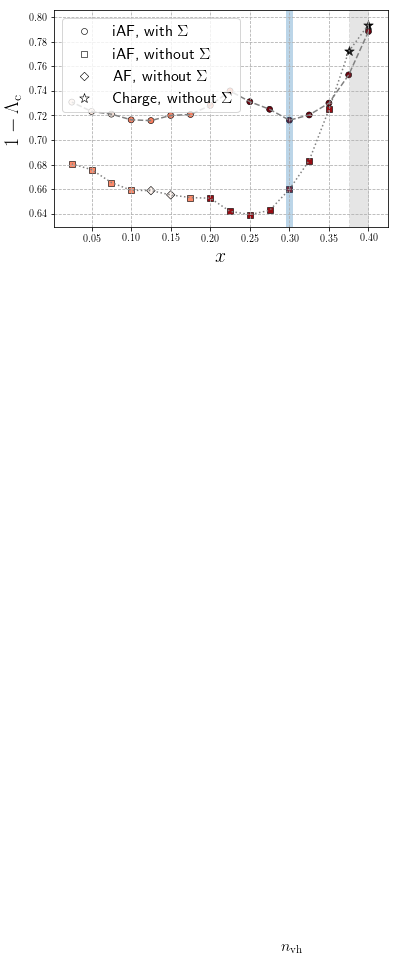

In [13]:
fig=plt.figure()
def form(a): 
    return "{:3.2f}".format(a)

ax = fig.add_subplot(111)

lcol=np.array(asscol(top,vectorst,'Reds'))[inco]
commcol = np.array(asscol(top,vectorst,'Reds'))[comme]
 
def util(a):
    return (1.-a)**2 
    #return a
plt.clf()
plt.plot(1.-top[:,4],util(top[:,0]),color='grey',linestyle='dotted')
plt.plot(1.-bottom[:,4],util(bottom[:,0]),color='grey',linestyle ='dashed')
plt.scatter(1.-bottom[:,4],util(bottom[:,0]),c=asscol(bottom,vectorsb,'Reds'),marker='o',edgecolor='black', linewidth='0.6',label =r'iAF, with $\Sigma$')# label = r'with $\Sigma$')
plt.scatter(1.-top[inco,4],util(top[inco,0]),c=lcol, marker='s',edgecolor='black', linewidth='0.6', label = r'iAF, without $\Sigma$')#,label =r'without $\Sigma$')
plt.scatter(1.-top[comme,4],util(top[comme,0]),c=commcol, marker='D',edgecolor='black', linewidth='0.6', label = r'AF, without $\Sigma$')


if np.sum([1. for v in top[top[:,5]==1.]])>0.5 :     
    plt.axvspan(1.-np.min(top[top[:,5]==1,4]),1.-np.max(top[top[:,5]==1,4]),linestyle ='dashed',color = 'grey',alpha=0.2)
    plt.scatter(1.-top[top[:,5]==1.,4],util(top[top[:,5]==1.,0]),c='black', s = 100.0, marker='*', edgecolor='black', linewidth='0.6',label =r'Charge, without $\Sigma$')#,label =r'without $\Sigma$')


rectangles = False
if rectangles : 
    for i in range(1,vectorsb.shape[0]-1): 
        #lab = r'('+form(vectorsb[i][0])+r','+form(vectorsb[i][1])+r')'
        ax.axvspan(recb[i],recb[i+1],alpha=0.5,fill=False, linestyle = 'dashed')# color = colorsb[i],label=lab) 
    for i in range(1,vectorst.shape[0]-1):
        ax.axvspan(rect[i],rect[i+1],alpha=0.5,fill=False, linestyle = 'dotted')
plt.axvspan(0.296,0.304,alpha=0.3,fill='indigo')
#plt.ylim([0.06, 0.21])
plt.grid(linestyle='dashed')
plt.legend(fontsize = 16)
plt.xlabel(r"$x$",fontsize=20)
plt.ylabel(r"$1-\Lambda_{\mathrm{c}}$",fontsize=20)
plt.text(0.290,0.04,r"$n_{\mathrm{vh}}$",fontsize=16)
for i in  range(len(plt.gca().get_legend().legendHandles)):
    plt.gca().get_legend().legendHandles[i].set_color('white')
    plt.gca().get_legend().legendHandles[i].set_edgecolor('black')
plt.savefig('../images/ueff.png',dpi=300) 
#os.system('geequie /home/taranto/Documents/fRG_paper/imaeges/criscale.png &')